In [1]:
## Enviroment Setup
import os, sys
os.environ['CUDA_VISIBLE_DEVICES'] = '0' # Set the visible CUDA
WORKING_DIR = '/home/peizhi/Documents/gaussian-dejavu/'
os.chdir(WORKING_DIR) # change the working directory to the project's absolute path
print("Current Working Directory: ", os.getcwd())
sys.path.append(WORKING_DIR)
sys.path.append('./models')
sys.path.append('./networks')
sys.path.append('./utils')
sys.path.append('./utils/flame_lib/')
sys.path.append('./utils/diff-gaussian-rasterization')
sys.path.append('./utils/gaussian_renderer')
sys.path.append('./utils/scene')
sys.path.append('./utils/arguments')
sys.path.append('./utils/simple-knn')

import matplotlib.pyplot as plt
from time import time
from tqdm import tqdm
import numpy as np
import cv2
import torch

from dejavu import GaussianDejavu
from utils.personal_video_utils import *

def min_max_normalize(image):
    norm_image = (image - np.min(image)) / (np.max(image) - np.min(image))
    return norm_image

dejavu = GaussianDejavu(network_weights='./models/dejavu_network.pt', uv_map_size=320)
device = dejavu.device




Current Working Directory:  /home/peizhi/Documents/gaussian-dejavu
creating the FLAME Decoder


/home/peizhi/Documents/gaussian-dejavu/utils/flame_lib/FLAME.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('dynamic_lmk_faces_idx', torch.tensor(lmk_embeddings['dynamic_lmk_faces_idx'], dtype=torch.long))
/home/peizhi/Documents/gaussian-dejavu/utils/flame_lib/FLAME.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('dynamic_lmk_bary_coords', torch.tensor(lmk_embeddings['dynamic_lmk_bary_coords'], dtype=self.dtype))
/home/peizhi/miniconda3/envs/dejavu/lib/python3.10/site-packages/pytorch3d/io/obj_io.py:550: UserWarning: Mtl file does not exist: ./models/head_template2.mtl
  warnings.warn(f"Mtl file does not exist: {f}")


Framework v1.0 initialized.
Number of Gaussians:  74083
model loaded from:  ./models/dejavu_network.pt
Gaussian DejaVu Framework Created.


## Personal Data Loader

Number of frames: 4561.
img torch.Size([3, 512, 512, 3])
parsing (3, 512, 512)
img_aligned torch.Size([3, 512, 512, 3])
parsing_aligned torch.Size([3, 512, 512])
blendshape_scores torch.Size([3, 52])
shape torch.Size([3, 100])
exp torch.Size([3, 50])
head_pose torch.Size([3, 3])
jaw_pose torch.Size([3, 3])
eye_pose torch.Size([3, 6])
tex torch.Size([3, 50])
light torch.Size([3, 9, 3])
cam torch.Size([3, 6])
fov (3,)
img_masked torch.Size([3, 512, 512, 3])
masks torch.Size([3, 512, 512, 1])
img_aligned_masked torch.Size([3, 512, 512, 3])


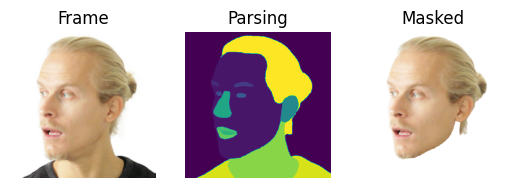

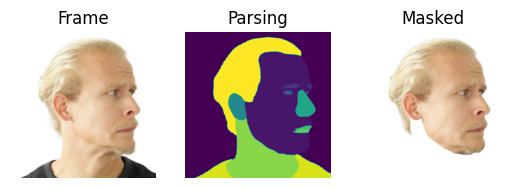

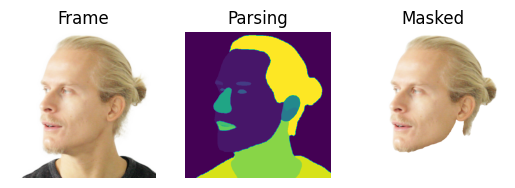

In [2]:
# Please first follow the flame-head-tracker to reconstruct the FLAME parameters  
# https://github.com/PeizhiYan/flame-head-tracker

# dataset_path = '/mnt/data4_hdd/peizhi/Datasets/inhouse-blendshapes/Peizhi-Demo-v4.1-photometric'
# dataset_path = '/mnt/data4_hdd/peizhi/Datasets/avatar-datasets-processed/IMAvatar_tracker_4.1/subject1'
dataset_path = '/mnt/data4_hdd/peizhi/Datasets/avatar-datasets-processed/IMAvatar_tracker_4.1/subject2'
personal_dataloader = PersonalDataLoader(dataset_path=dataset_path, device=device, shuffle=True)

batch_data = personal_dataloader.next_random_batch(batch_size=3)

for key in batch_data:
    try:
        print(key, batch_data[key].shape)
    except:
        pass

for i in range(len(batch_data['fid'])):    
    plt.figure()
    plt.subplot(1,3,1)
    plt.imshow(batch_data['img'][i].detach().cpu()); plt.axis('off'); plt.title('Frame')
    plt.subplot(1,3,2)
    plt.imshow(batch_data['parsing'][i]); plt.axis('off'); plt.title('Parsing')
    plt.subplot(1,3,3)
    plt.imshow(batch_data['img_masked'][i].detach().cpu()); plt.axis('off'); plt.title('Masked')
    plt.show()



## Train

In [3]:

# v1.4
dejavu.personal_video_training(personal_dataloader, batch_size=16, steps_s1=150, steps_s2=500)




/home/peizhi/miniconda3/envs/dejavu/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/home/peizhi/miniconda3/envs/dejavu/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/peizhi/miniconda3/envs/dejavu/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/peizhi/miniconda3/envs/dejavu/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


  0%|          | 0/150 [00:00<?, ?it/s]/home/peizhi/Documents/gaussian-dejavu/utils/scene/cameras.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  world_view_transform = torch.tensor(cam.world_view_transform).float().to(device)
/home/peizhi/Documents/gaussian-dejavu/utils/scene/cameras.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  full_proj_transform = torch.tensor(cam.full_proj_transform).float().to(device)
Training Global...  Loss: 0.0060 LR: 0.0055: 100%|██████████| 150/150 [02:25<00:00,  1.03it/s]


Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/peizhi/miniconda3/envs/dejavu/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


Training Blendmaps...  Loss: 0.0077 LR: 0.0068: 100%|██████████| 500/500 [09:38<00:00,  1.16s/it]


## Compare Results

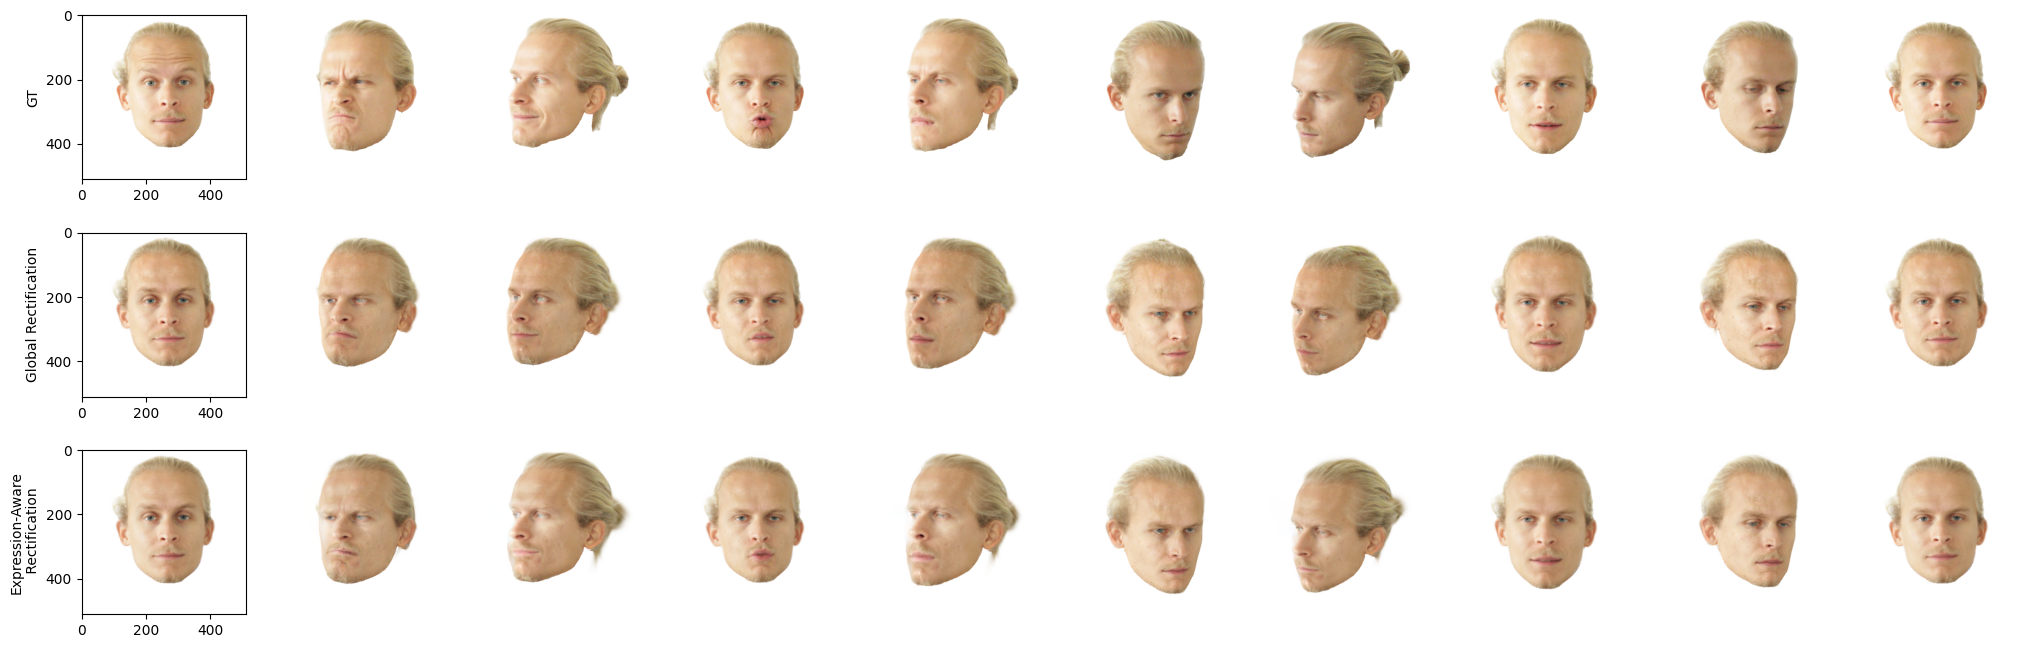

In [4]:

plt.figure(figsize=(25,8))

num_examples = 10
for i in range(num_examples):
    batch_data_test = personal_dataloader.next_random_batch(vid=None, batch_size=1)

    # Ground-Truth Frames (First Row)
    plt.subplot(3,num_examples,i+1)
    plt.imshow(batch_data_test['img_masked'][0].detach().cpu()); plt.axis('off')
    if i == 0: plt.ylabel('GT'); plt.axis('on')

    # Reconstructed, w/ Global Rectification (Second Row)
    plt.subplot(3,num_examples,num_examples+i+1)
    batch_rendered_global = dejavu._render_with_global_offsets_(batch_data_test, dejavu.global_uv_delta)
    plt.imshow(np.clip(batch_rendered_global[0].detach().cpu().permute(1,2,0),0,1.0)); plt.axis('off')
    if i == 0: plt.ylabel('Global Rectification'); plt.axis('on')

    # Reconstructed, w/ Expression-Aware Rectification (Third Row)
    plt.subplot(3,num_examples,2*num_examples+i+1)
    batch_rendered_blend, _ = dejavu._render_with_blendmaps_(batch_data_test, dejavu.uv_delta_blendmaps)
    plt.imshow(np.clip(batch_rendered_blend[0].detach().cpu().permute(1,2,0),0,1.0)); plt.axis('off')
    if i == 0: plt.ylabel('Expression-Aware\n Rectification'); plt.axis('on')

plt.show()



## Save Head Avatar

In [5]:
## save head avatar

# dejavu.save_head_avatar(save_path='./saved_avatars', avatar_name='peizhi-v1.4')
# dejavu.save_head_avatar(save_path='./saved_avatars', avatar_name='imavatar-subject1-v1.4')
dejavu.save_head_avatar(save_path='./saved_avatars', avatar_name='imavatar-subject2-v1.4')


Head avatar parameters saved to ./saved_avatars/imavatar-subject2-v1.4


## Load Head Avatar

In [ ]:
## load head avatar

# dejavu.load_head_avatar(save_path='./saved_avatars', avatar_name='peizhi-v1.4')
# dejavu.load_head_avatar(save_path='./saved_avatars', avatar_name='imavatar-subject1-v1.4')
# dejavu.load_head_avatar(save_path='./saved_avatars', avatar_name='imavatar-subject2-v1.4')


Head avatar parameters loaded
